# Autoenkoderi

Autoenkoderi predstavljaju neuronske mreže koje pokušavaju da nauče funkciju `f(x)=x` tj. da reprodukuju svoj ulaz. Ovakve mreže se sastoje iz dva dela: enkodera i dekodera.

`Enkoder` predstavlja deo mreže koji ulaz dimenzije $A$ preslikava u vektor dimenzije $B$, pri čemu važi da je $A > B$, odnosno vrši se smanjivanje dimenzionalnosti. Vektor dimenzije $B$ nazivamo vektorom latentnog prostora dimenzije $B$.

`Dekoder` dobijeni vektor dimenzije $B$ preslikava u polazni vektor dimenzije $A$, odnosno vrši rekonstrukciju ulaza na osnovu vektora iz latentnog prostora.

<img src='assets/autoencoder_1.png'>

Treniranje autoenkodera se vrši kao obučavanje standardne neuronske mreže u klasifikacionim i regresionim problemima.
Ono što nas u radu sa njima najviše zanima je latentni prostor i reprezentacije ulaza koje su obično značajno manjih dimenzija. Na primer, u radu sa tekstom smo koristili pritrenirane GloVe i Word2Vec reprezentacije koje su dobijene treniranjem specifičnih autoenkodera. 

Sledeći primer prikazuje ipak nešto malo drugačiji scenario primene autoenkodera kojim se uklanja šum (engl. denoising autoencoder) sa slike.  

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [4]:
np.random.seed(1337)

Prvo ćemo učitati skup podataka. Same labele koje su pridružene instancama nisu od važnosti za autoenkodere.

In [5]:
(X_train, _), (X_test, _) = mnist.load_data()

Sličice sa kojima radimo su dimenzija 28x28 i pripremićemo ih tako što ćemo ih ispraviti i normalizovati njihove vrednosti. Uz ovo, slikama ćemo pridružiti i dodatnu dimenziju sa vrednošću 1 koja predstavlja njihov kanal (slike su crno-bele).

In [6]:
image_size = X_train.shape[1]
print(image_size)

28


In [7]:
X_train = np.reshape(X_train, (-1, image_size, image_size, 1))
X_train = X_train.astype('float32') / 255

X_test = np.reshape(X_test, (-1, image_size, image_size, 1))
X_test = X_test.astype('float32') / 255

In [8]:
X_train.shape

(60000, 28, 28, 1)

In [9]:
X_test.shape

(10000, 28, 28, 1)

Dalje ćemo generisati šum iz raspodele $N(0.5, 0.5)$ koji ćemo dodati slikama. 

In [10]:
noise = np.random.normal(loc=0.5, scale=0.5, size=X_train.shape)
X_train_noisy = X_train + noise

noise = np.random.normal(loc=0.5, scale=0.5, size=X_test.shape)
X_test_noisy = X_test + noise

# odsecicemo vrednosti koje su nakon dodavanja suma ispale iz opsega [0, 1]
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

Prikazaćemo npr. 9 ovako dobijenih modifikovanih sličica.

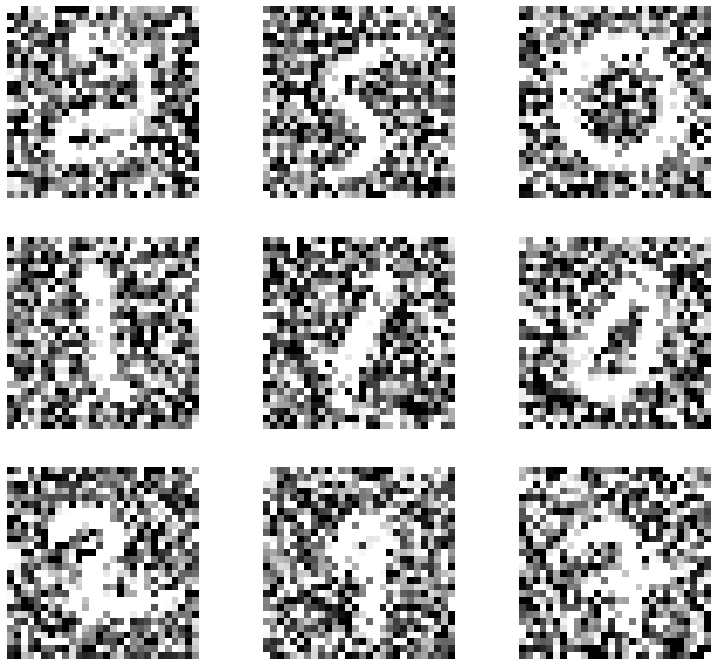

In [11]:
nrows = 3
ncols = 3

# pripremamo panel za crtanje svake od sličica
fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(13, 12)

# izdvajamo nrows*ncols slika nasumicno
ix = np.random.randint(low=0, high=X_train_noisy.shape[0], size=nrows*ncols)
chosen_imgs = X_train_noisy[ix]

# svaku slicicu zasebno prikazujemo
i = 0
for row in ax:
    for col in row:
        # pre prikaza menjamo dimenziju slike iz (image_size, image_size, 1) 
        # u (image_size, image_size) jer matplotlib to zahteva zbog crtanja
        img = chosen_imgs[i].reshape(image_size, image_size)
        col.imshow(img, cmap='gray')
        col.axis('off')
        i += 1
        
plt.show()       

Dalje ćemo definisati parametre mreže. Ulaz u mrežu je tenzor oblika $(28, 28, 1)$ gde je $28 \times 28$ dimezija slike, a $1$ naznaka da postoji 1 kanal slike jer su slike crno-bele. Slike ćemo preslikavati u vektor dimenzije 16.

In [12]:
input_shape = (image_size, image_size, 1)
latent_dim = 16

## Enkoder

Enkoder će biti konvolutivna mreža koja preslikava tenzor dimenzija (28, 28, 1) u vektor dimenzije 16.

In [13]:
# velicina kernela
kernel_size = 3

# broj filtera u konvolutivnim slojevima
layer_filters = [32, 64]

Za kreiranje mreže koristićemo funkcionalni API Keras biblioteke.

In [14]:
# imamo ulazni sloj
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# zatim dva konvolutivna sloja 
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# ocitacemo i sacuvati dimenzije ovako dobijenog tenzora 
# (None, 7, 7, 64) 
shape = K.int_shape(x)

# potom sledi sloj za ispravljanje
x = Flatten()(x)

# pa gusti sloj koji generise latentnu reprezentaciju
latent_outputs = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs=inputs, outputs=latent_outputs, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


## Dekoder

Dekoder će biti konvolutivna neuronska mreža koja preslikava vektor dimenzije 16 u tenzor dimenzija (28, 28, 1).

In [43]:
# velicina kernela
kernel_size = 3

# broj filtera u konvolutivnim slojevima
layer_filters = [32, 64]

In [15]:
# prvo imamo ulazni sloj
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

# potom jedan gusti sloj kojim ulaz prosirujemo na dimenziju (None, 7, 7, 64)
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# mrezi dodajemo transponovane konvolutivne slojeve obrnutim redosledom u odnosu na enkoder
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                    kernel_size=kernel_size,
                    strides=2,
                    activation='relu',
                    padding='same')(x)

# zatim dodajemo jos jedan transponovani konvolutivni sloj kojim kontrolišemo dimenziju kanala    
x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

# i jedan aktivacioni sloj sa sigmoidnom aktivacijom
outputs = Activation('sigmoid', name='decoder_output')(x)

decoder = Model(inputs=latent_inputs, outputs=outputs, name='decoder')
decoder.summary(line_length=110)

Model: "decoder"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
decoder_input (InputLayer)                       [(None, 16)]                                0                
______________________________________________________________________________________________________________
dense (Dense)                                    (None, 3136)                                53312            
______________________________________________________________________________________________________________
reshape (Reshape)                                (None, 7, 7, 64)                            0                
______________________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspose)               (None, 14, 14, 64)                          36

Dalje koristimo konstruisane modele da napravimo autoenkoder.

In [16]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [17]:
autoencoder.compile(loss='mse', optimizer='adam')

Dalje vršimo treniranje autoenkodera. Autoenkoder kao ulaze ima instance kojima je dodat šum, a kao izlaze instance na kojima ne postoji šum. Tako će naučiti da ignoriše šum tj. da rekonstruiše sličice.

In [18]:
batch_size = 128
epochs = 30

Možete otići po kafu i vratiti se za sat vremena ;-)

In [38]:
autoencoder.fit(X_train_noisy,
                X_train,
                validation_data=(X_test_noisy, X_test),
                epochs=epochs,
                batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 154s 3ms/step - loss: 0.0625 - val_loss: 0.0320
Epoch 2/30
60000/60000 [==============================] - 128s 2ms/step - loss: 0.0255 - val_loss: 0.0218
Epoch 3/30
60000/60000 [==============================] - 127s 2ms/step - loss: 0.0210 - val_loss: 0.0196
Epoch 4/30
60000/60000 [==============================] - 118s 2ms/step - loss: 0.0191 - val_loss: 0.0183
Epoch 5/30
60000/60000 [==============================] - 117s 2ms/step - loss: 0.0181 - val_loss: 0.0176
Epoch 6/30
60000/60000 [==============================] - 116s 2ms/step - loss: 0.0174 - val_loss: 0.0173
Epoch 7/30
60000/60000 [==============================] - 117s 2ms/step - loss: 0.0170 - val_loss: 0.0169
Epoch 8/30
60000/60000 [==============================] - 110s 2ms/step - loss: 0.0166 - val_loss: 0.0167
Epoch 9/30
60000/60000 [==============================

Rezulat prethodnog treniranje je sačuvan u okviru `models` direktorijuma i može se iskoristiti umesto istreniranog modela.

In [40]:
# autoencoder.save('models/autoencoder.h5')

In [19]:
autoencoder = keras.models.load_model('models/autoencoder.h5')

Prikazaćemo i vizuelno kako autoenkoder radi. Generisaćemo slike na osnovu slika u test skupu, a zatim prikazati 300 njih: u 10 redova će se naći po 30 slika i to prvo originalnih, potom sa šumom, a potom i onih koje je generisao autoenkoder. 

In [20]:
X_decoded = autoencoder.predict(X_test_noisy)

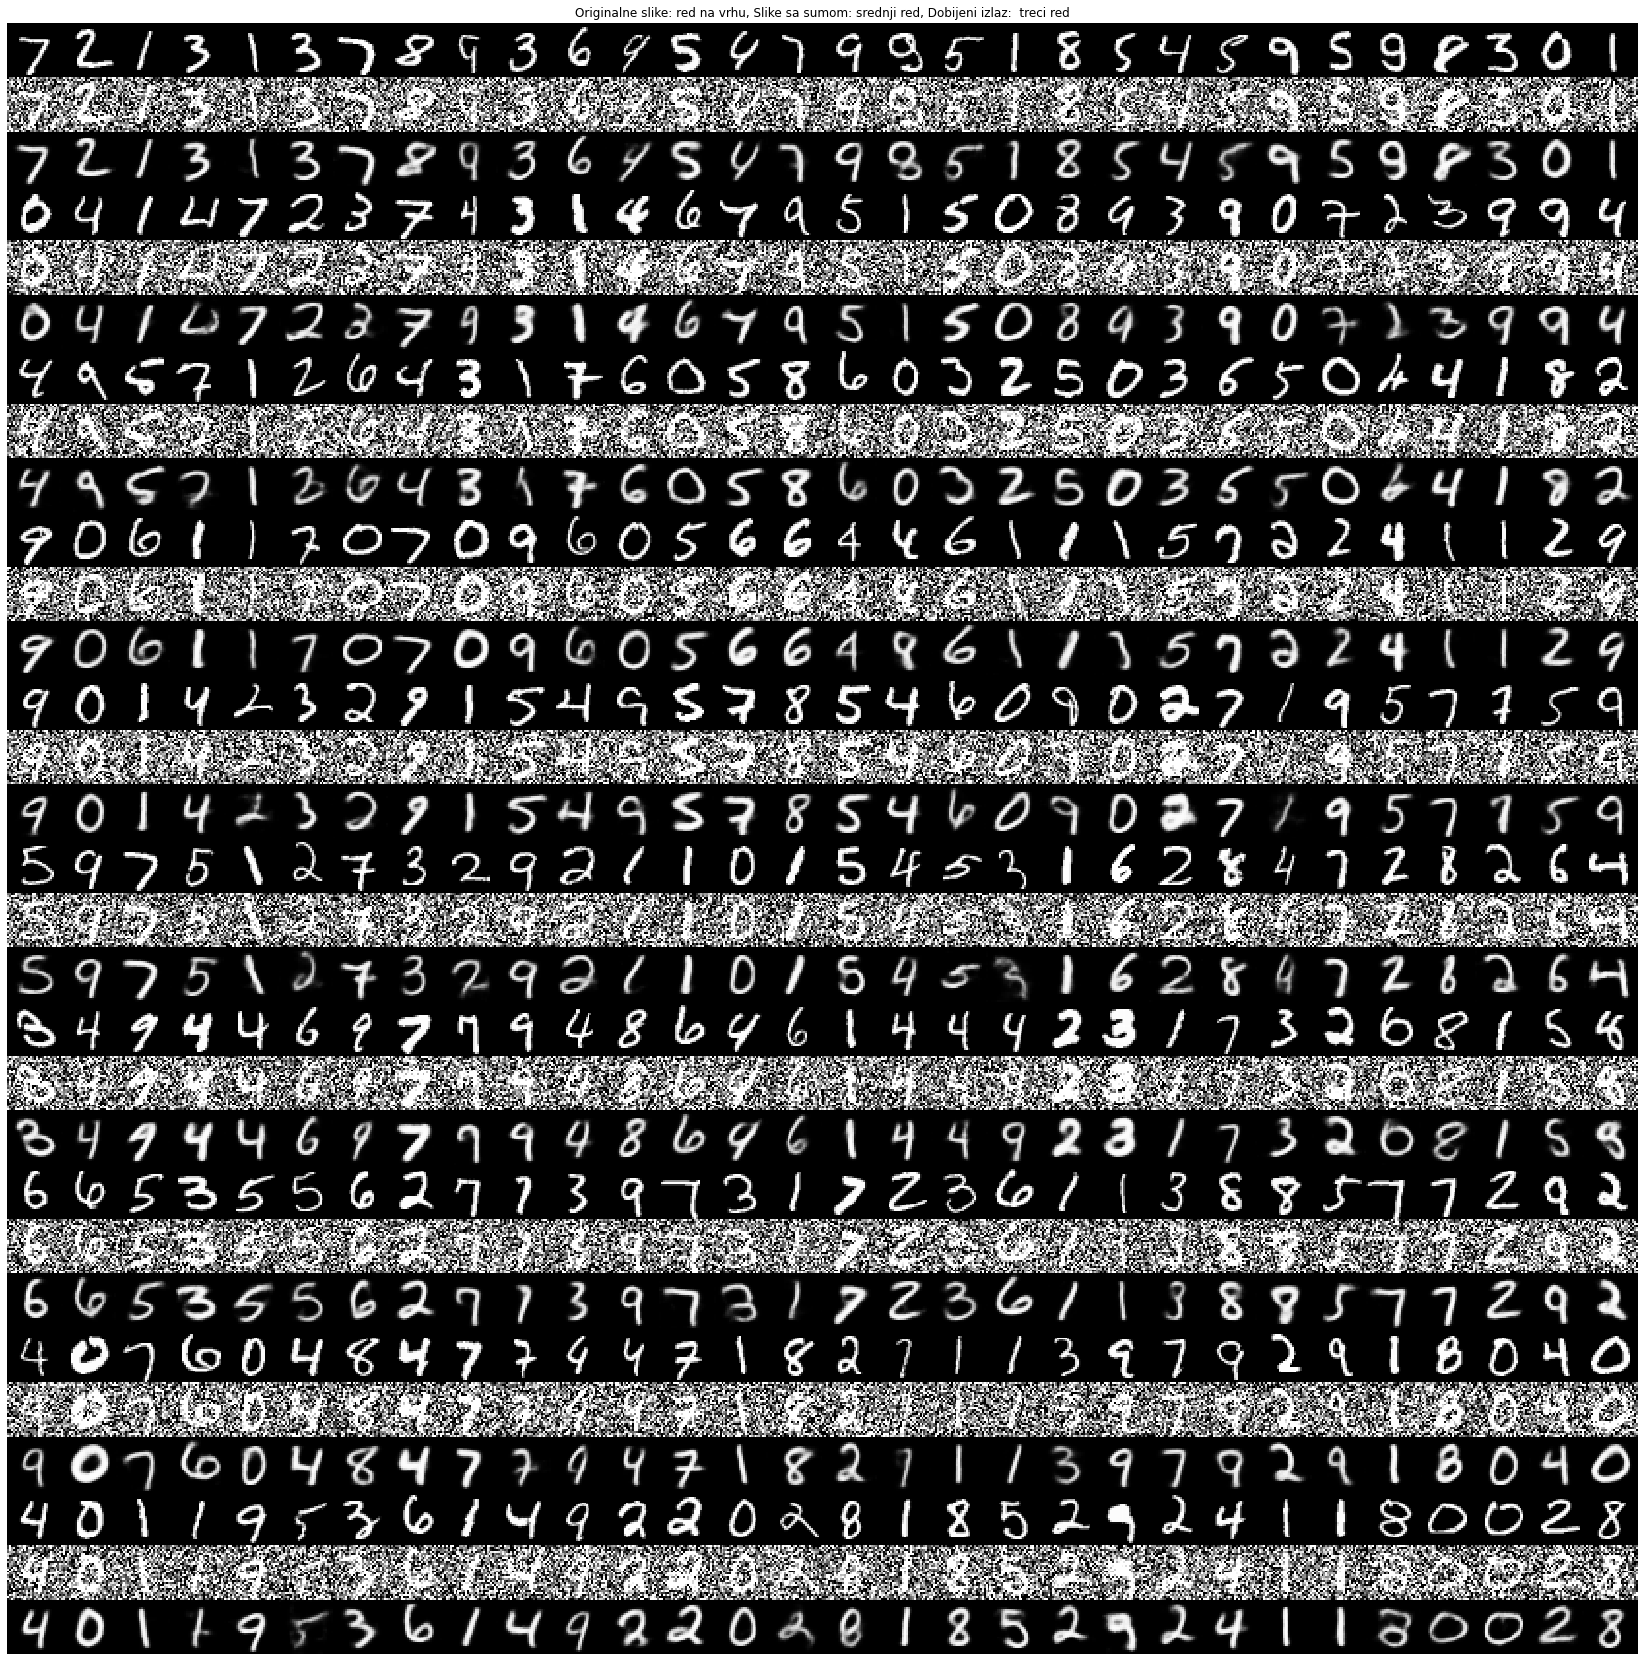

In [23]:
# pripremamo panel za crtanje
plt.figure(figsize=(30, 30))

# izdvojicemo 10x30 slika
rows, cols = 10, 30
num = rows * cols

# izdvajamo odgovarajuce slike: prvo orginalne, zatim sa sumom, a zatim i one koje je genrisao autoenkoder
imgs = np.concatenate([X_test[:num], X_test_noisy[:num], X_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))

# sličice organizujemo tako da imaju opisani oblik
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)

plt.axis('off')
plt.title('Originalne slike: red na vrhu, '
          'Slike sa sumom: srednji red, '
          'Dobijeni izlaz:  treci red')

# prikazujemo slike
plt.imshow(imgs, interpolation='none', cmap='gray')

# čuvamo ovako generisanu sliku
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()